In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import math
import sys
import re
import statistics
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import simple_lightGBM

In [2]:
df = pd.read_csv('data/DDG_Dataset.csv')
# df = pd.read_csv('data/DDG_Dataset_mini.csv')
df = df[df['Temperature'] != "'-"].reset_index(drop=True)
df['Temperature'] = df['Temperature'].astype('float64')
ndatas = df.shape[0]
print(df.columns)
print(ndatas)
df

Index(['Rowid', 'ID', 'Protein Name', 'Mutation', 'Chain', 'PDB',
       'Temperature', 'pH', 'ΔΔG', 'Reference', 'A', 'R', 'N', 'D', 'C', 'Q',
       'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V',
       'ASP', 'PHE', 'GLN', 'LYS', 'ILE', 'TYR', 'GLY', 'ASN', 'ARG', 'LEU',
       'TRP', 'ALA', 'THR', 'VAL', 'HIS', 'CYS', 'GLU', 'MET', 'PRO', 'SER'],
      dtype='object')
8535


,Rowid,ID,Protein Name,Mutation,Chain,PDB,Temperature,pH,ΔΔG,Reference,...,TRP,ALA,THR,VAL,HIS,CYS,GLU,MET,PRO,SER
0,1,1,Tryptophan synthase alpha chain,E49M,A,1WQ5,298.95,7.0,4.60,PMID: 378988,...,0.0,4.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0
1,2,2,Tryptophan synthase alpha chain,E49Q,A,1WQ5,298.95,7.0,-2.50,PMID: 378988,...,0.0,4.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0
2,3,3,Endolysin,W138Y,A,2LZM,298.15,2.2,-1.71,PMID: 911878,...,0.0,5.0,4.0,4.0,0.0,0.0,2.0,2.0,1.0,2.0
3,4,6,Cellular tumor antigen p53,C242S,A,1TUP,283.15,7.2,-3.07,PMID: 1203434,...,0.0,0.0,0.0,1.0,2.0,4.0,2.0,3.0,1.0,2.0
4,5,7,Cellular tumor antigen p53,F134L,A,1TUP,283.15,7.2,-4.78,PMID: 1203434,...,0.0,2.0,5.0,3.0,0.0,5.0,4.0,1.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8530,8570,13318,Transcriptional repressor arc,V25A,A,1ARR,298.15,7.5,-0.40,PMID: 7664079,...,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,1.0
8531,8571,13319,Transcriptional repressor arc,V18A,A,1ARR,298.15,7.5,-0.50,PMID: 7664079,...,1.0,1.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,0.0
8532,8572,13320,Transcriptional repressor arc,V33A,A,1ARR,298.15,7.5,-2.10,PMID: 7664079,...,1.0,1.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,2.0
8533,8573,13321,Transcriptional repressor arc,S32A,A,1ARR,298.15,7.5,-3.80,PMID: 7664079,...,0.0,1.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.0


In [3]:
# df['Temperature'] = df['Temperature'].astype('float64')
df['Temperature'] = df['Temperature'].astype('float64')
# print(df['Temperature'].unique())
data_df = df.drop(columns=['Rowid', 'ID', 'Protein Name', 'Mutation', 'Chain', 'PDB', 'ΔΔG', 'Reference'])
data_x = data_df.to_numpy()
data_y = df['ΔΔG'].to_numpy()

In [4]:
os.system('mkdir -p data/boruta')
for r in range(data_x.shape[1]):
    print('try {}'.format(r))
    tmp_data_x = np.copy(data_x)
    random_list = random.choices(sorted(np.unique(tmp_data_x[:, r])), k=ndatas)
    tmp_data_x[:, r] = random_list
    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    pred_y = np.zeros(ndatas)
    feature_importance = np.zeros(tmp_data_x.shape[1])
    for index, (train_indices, valid_indices) in enumerate(kf.split(range(ndatas))):
        # print(index)
        # print(train_indices)
        # print(valid_indices)
        train_x, test_x = tmp_data_x[train_indices], tmp_data_x[valid_indices] 
        train_y = data_y[train_indices]
        pred_y[valid_indices], importances = simple_lightGBM.predict(train_x, train_y, test_x)

        tmp_df = df.copy()
        tmp_df['rand_items'] = random_list
        tmp_df['pred_ΔΔG'] = pred_y
        tmp_df.to_csv('data/boruta/pred_DDG_Dataset_lightGBM_{}.csv'.format(r), index=False)

try 0
try 1
try 2
try 3
try 4
try 5
try 6
try 7
try 8
try 9
try 10
try 11
try 12
try 13
try 14
try 15
try 16
try 17
try 18
try 19
try 20
try 21
try 22
try 23
try 24
try 25
try 26
try 27
try 28
try 29
try 30
try 31
try 32
try 33
try 34
try 35
try 36
try 37
try 38
try 39
try 40
try 41


In [5]:
result_df = pd.read_csv('data/pred_DDG_Dataset_lightGBM.csv')
origin_mse = mean_squared_error(result_df['ΔΔG'], result_df['pred_ΔΔG'])

mses = []
for r in range(data_x.shape[1]):
    tmp_result_df = pd.read_csv('data/boruta/pred_DDG_Dataset_lightGBM_{}.csv'.format(r))
    mses.append(mean_squared_error(tmp_result_df['ΔΔG'], tmp_result_df['pred_ΔΔG']))

<BarContainer object of 42 artists>

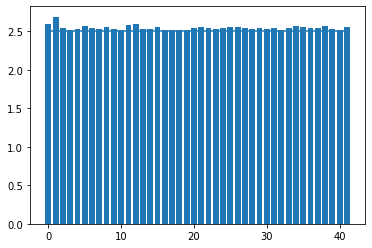

In [6]:
plt.plot(range(data_x.shape[1]), [origin_mse for i in range(data_x.shape[1])])
plt.bar(range(data_x.shape[1]), mses)

<BarContainer object of 42 artists>

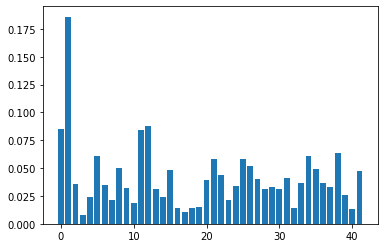

In [7]:
plt.bar(range(data_x.shape[1]), [mses[i] - origin_mse for i in range(data_x.shape[1])])